In [1]:
import time, sys, joblib

import pandas as pd
sys.path.append('/home/yilingh/SI-Interaction')
from selectinf.Simulation.plotting_helpers import *
from selectinf.Simulation.H1.nonlinear_H1_helpers import *

In [2]:
from operator import le, ge
def filter_pval_dict_new(target_dict, threshold=0.05, operator=le, p_flag="pivot"):
    grouped_targets = pd.DataFrame(target_dict).groupby(['parameter', 'method'])
    filtered_dict = {}
    # Filter by 
    for name, group in grouped_targets:
        # Subset the selected targets
        selected_targets_id = operator(np.abs(group['target']), threshold)
        selected_targets = group[p_flag][selected_targets_id]
        # Then filtered_dict.keys must be a dictionary
        if name[0] in filtered_dict.keys():
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        else:
            filtered_dict[name[0]] = {}
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        
    return filtered_dict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_MSE(oper_char):
    specific_method = "MLE"  # Replace with the name of your method
    
    # Create a modified DataFrame
    df_modified = oper_char.copy()
    
    # For the specific method, keep "tau" values separate
    # For other methods, set "tau" to a single category, e.g., "All"
    df_modified['prop'] = df_modified.apply(
        lambda row: row['prop'] if row['method'] == specific_method else 'Naive/DS', axis=1
    )
    
    # Plotting
    sns.boxplot(x='method', y='MSE', hue='prop', data=df_modified, showmeans=True)
    plt.xlabel("Method")
    plt.ylabel("MSE")
    plt.title("Boxplot of MSE by Method and prop")
    plt.show()


In [3]:
def combine_dicts(dict, new_dict):
    for key in dict.keys():
        dict[key] = dict[key] + new_dict[key]
        
    return dict

In [4]:
def combine_nested_dicts(dict, new_dict):
    combined_dict = {}
    for key in dict.keys():
        combined_dict[key] = combine_dicts(dict[key], new_dict[key])
    
    return combined_dict

# Vary sparsity with weak Hierarchy

In [5]:
n_task_per_file = 25
n_files = 10
base_dir = "vary_signal_"
files_list = []
for i in range(n_files):
    dir = base_dir + str(i*n_task_per_file) + "_"  + str((i+1)*n_task_per_file) + ".pkl"
    files_list.append(dir)

In [6]:
oper_char_full = None
ds_rank_def_count_full = None
target_dict_full = None
pval_dict_full = None
MSE_dict_full = None
F1_dict_full = None

for path in files_list:
    print(path)
    ds_rank_def_count, target_dict, pval_dict, MSE_dict, oper_char, F1_dict = joblib.load(path)
    # Combine ds_rank_def_count
    if not ds_rank_def_count_full:
        ds_rank_def_count_full = ds_rank_def_count
    else:
        ds_rank_def_count_full = combine_dicts(ds_rank_def_count_full, ds_rank_def_count)
    # Combine target_dict
    if not target_dict_full:
        target_dict_full = target_dict
    else:
        target_dict_full = combine_dicts(target_dict_full, target_dict)
    if not pval_dict_full:
        pval_dict_full = pval_dict
    else:
        pval_dict_full = combine_nested_dicts(pval_dict_full, pval_dict)
    # Combine MSE_dict
    if not MSE_dict_full:
        MSE_dict_full = MSE_dict
    else:
        MSE_dict_full = combine_dicts(MSE_dict_full, MSE_dict)
    # Combine oper_char
    if not oper_char_full:
        oper_char_full = oper_char
    else:
        oper_char_full = combine_dicts(oper_char_full, oper_char)
    # Combine oper_char
    if not F1_dict_full:
        F1_dict_full = F1_dict
    else:
        F1_dict_full = combine_dicts(F1_dict_full, F1_dict)

vary_signal_0_25.pkl
vary_signal_25_50.pkl
vary_signal_50_75.pkl
vary_signal_75_100.pkl
vary_signal_100_125.pkl
vary_signal_125_150.pkl
vary_signal_150_175.pkl
vary_signal_175_200.pkl
vary_signal_200_225.pkl
vary_signal_225_250.pkl


In [7]:
ds_rank_def_count_full

{4.0: 29, 2.0: 104, 1.0: 198, 0.5: 228}

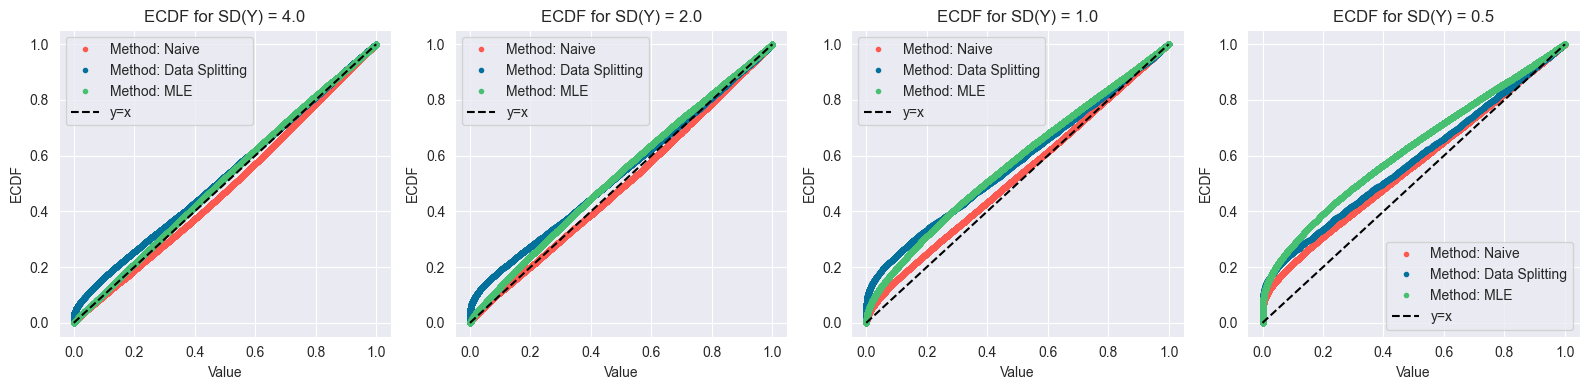

In [8]:
plot_ecdfs(pval_dict_full, xaxis="SD(Y)")

In [9]:
## Plotting dict: SNR - Method - List of pvals
filtered_dict = filter_pval_dict_new(target_dict, threshold = 0,
                                     operator=ge)

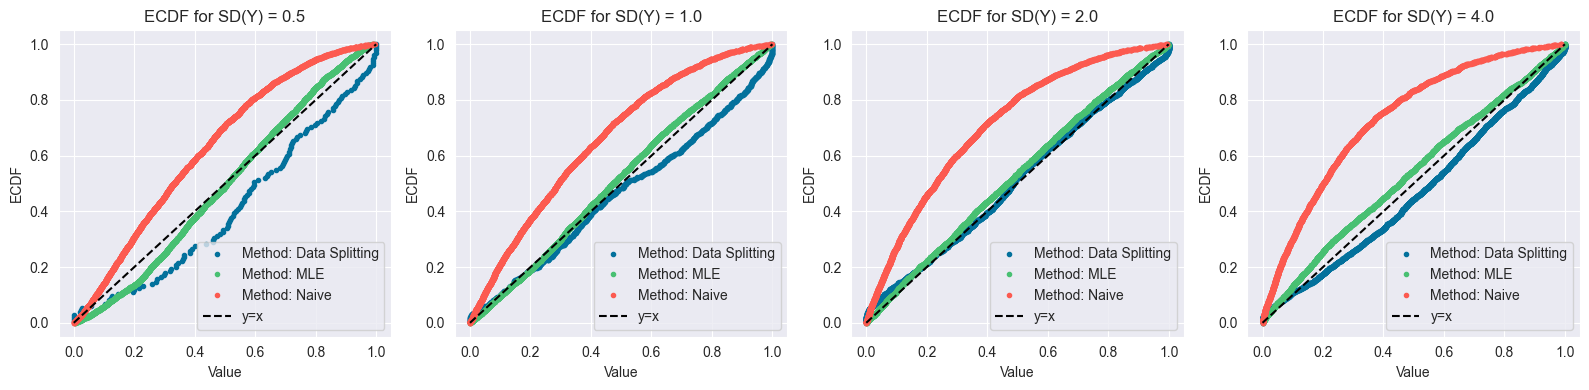

In [10]:
plot_ecdfs(filtered_dict, xaxis="SD(Y)")

In [11]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })

Text(0, 0.5, 'Average Length')

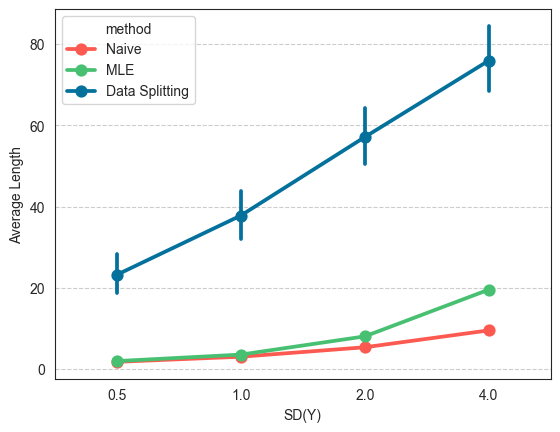

In [12]:
sns.pointplot(x=pd.DataFrame(oper_char_full)["sd_y"],
              y=pd.DataFrame(oper_char_full)["avg length"],
              hue=pd.DataFrame(oper_char_full)["method"], markers='o',
              palette=my_palette)
#plt.ylim(10,35)
plt.xlabel(r"SD(Y)")
plt.ylabel("Average Length")

Text(0, 0.5, 'Test MSE')

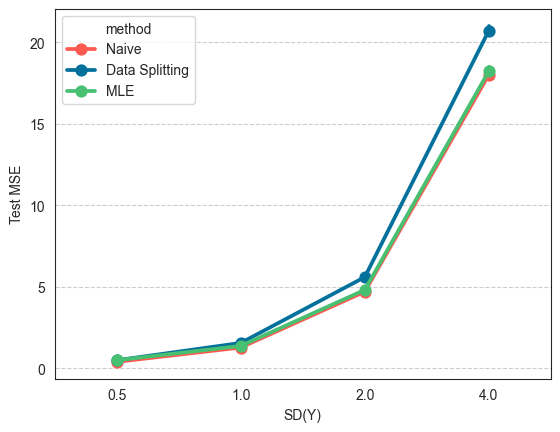

In [13]:
sns.pointplot(x=pd.DataFrame(MSE_dict_full)["sd_y"],
              y=pd.DataFrame(MSE_dict_full)["MSE"],
              hue=pd.DataFrame(MSE_dict_full)["method"], markers='o',
              palette=my_palette)
#plt.ylim(25,30)
plt.xlabel(r"SD(Y)")
plt.ylabel("Test MSE")

Text(0, 0.5, 'F1 score')

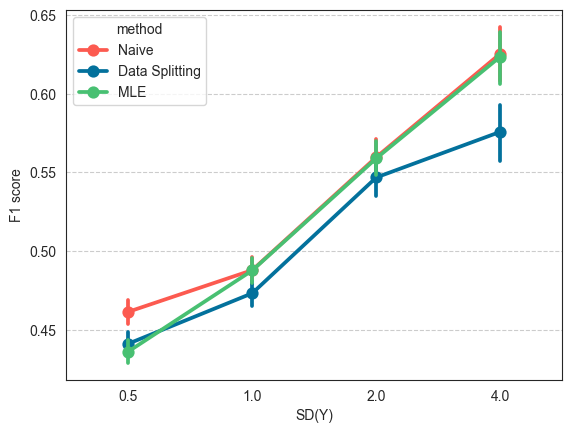

In [14]:
sns.pointplot(x=pd.DataFrame(F1_dict_full)["sd_y"],
              y=pd.DataFrame(F1_dict_full)["F1"],
              hue=pd.DataFrame(F1_dict_full)["method"], markers='o',
              palette=my_palette)
#plt.ylim(25,30)
plt.xlabel("SD(Y)")
plt.ylabel("F1 score")

# Applying BY Correction to the p-values

In [15]:
from collections import defaultdict
from scipy.stats import false_discovery_control


def add_BY_pval_by_method_and_index(data):
    # Check if BYpval is there
    if "BYpval" in data.keys():
        return
    # Assuming your dictionary is named 'data' and structured as described
    methods = data['method']
    indices = data['index']
    pvals = data['pval']

    # Initialize default dictionaries to collect p-values and positions for each (method, index) pair
    pvals_dict = defaultdict(list)
    pos_dict = defaultdict(list)

    # Iterate over the data and populate the dictionaries
    for i, (method, index, pval) in enumerate(zip(methods, indices, pvals)):
        key = (method, index)
        pvals_dict[key].append(pval)
        pos_dict[key].append(i)

    # Initialize BYpvals array with the same length as pvals
    BYpvals = [0] * len(pvals)  # or use numpy.zeros_like(pvals) if pvals is a numpy array

    # Apply BY correction and assign back to positions
    for key in pvals_dict:
        pvals_list = pvals_dict[key]
        positions = pos_dict[key]
        corrected_pvals = false_discovery_control(pvals_list, method='by')
        for pos, by_pval in zip(positions, corrected_pvals):
            BYpvals[pos] = by_pval

    # Add BYpvals to the original data dictionary
    data['BYpvals'] = BYpvals

    # Now, pvals_dict contains lists of p-values for each unique (method, index) pair

In [16]:
add_BY_pval_by_method_and_index(target_dict_full)

In [17]:
pd.DataFrame(target_dict_full)

,parameter,target,target id,method,index,pivot,pval,BYpvals
0,4.0,4.592075,"(0, 1)",Naive,0,0.369942,0.669320,1.000000
1,4.0,3.079235,"(0, 2)",Naive,0,0.067709,0.747353,1.000000
2,4.0,0.975945,"(0, 3)",Naive,0,0.285726,0.848712,1.000000
3,4.0,2.372296,"(0, 4)",Naive,0,0.755977,0.252517,1.000000
4,4.0,2.101571,"(0, 5)",Naive,0,0.265281,0.835286,1.000000
...,...,...,...,...,...,...,...,...
303127,0.5,0.357535,"(15, 18)",MLE,249,0.466129,0.502837,1.000000
303128,0.5,0.510705,"(15, 19)",MLE,249,0.687427,0.304433,1.000000
303129,0.5,0.799013,"(16, 19)",MLE,249,0.937718,0.000915,0.073568
303130,0.5,0.510471,"(17, 19)",MLE,249,0.755969,0.056605,1.000000


In [18]:
pd.DataFrame(target_dict_full).groupby(['parameter', 'method', 'index'])['BYpvals'].apply(lambda x: np.mean(x < 0.1)).groupby(level=['parameter', 'method']).apply(np.mean)

parameter  method        
0.5        Data Splitting    0.081897
           MLE               0.054290
           Naive             0.040536
1.0        Data Splitting    0.069698
           MLE               0.014635
           Naive             0.006489
2.0        Data Splitting    0.042332
           MLE               0.003299
           Naive             0.001105
4.0        Data Splitting    0.024171
           MLE               0.002131
           Naive             0.000647
Name: BYpvals, dtype: float64

# F1 score plot for interaction p-values without BY

In [19]:
def calculate_metrics(pvalue, targets, level, type, threshold=0.05):
    # Type = "Total", "Rej", "NonNull", "TP", "TN", "FP", "FN" 
    pvalue = np.array(pvalue)
    targets = np.array(targets)
    non_null = np.abs(targets) >= threshold
    rejection = pvalue < level
    null = np.abs(targets) < threshold
    acceptance = pvalue >= level
    TP = np.sum(non_null * rejection)
    FP = np.sum(null * rejection)
    TN = np.sum(null * acceptance)
    FN = np.sum(non_null * acceptance)
    
    prec = TP/(TP + FP) if (np.sum(rejection) > 0) else 0
    recall = TP/(TP + FN) if (TP + FN > 0) else 0
    FDR = FP/(TP + FP) if (np.sum(rejection) > 0) else 0
    FPR = FP/(FP + TN) if (FP + TN > 0) else 0
    def E(s, p):
        return -np.sqrt((1-2*p)**2/4-2*s)-(1-2*p)/2
    if type == "Prec":
        return prec
    if type == "Recall":
        return recall
    if type == "FDR":
        return FDR
    if type == "FPR":
        return FPR
    if type == "F1":
        return 2 * prec * recall / (prec + recall) if (prec * recall != 0) else 0
    if type == "N_rej":
        return np.sum(rejection)
        

def calculate_metric_df(targets_dict,
                          threshold=0.1,
                          level=0.1,
                          pval_key="pvals",
                        metric_list = ["Prec", "Recall", "FDR", "NonNull/Total"],
                        rank_def_count=None):
    grouped_targets = pd.DataFrame(targets_dict).groupby(['index',
                                                          'method', 'parameter'])
    power_df = {}
    power_df['parameter'] = []
    power_df['method'] = []
    """metric_list = ["Total", "Card", "Rej", "NonNull", 
                   "TP", "TN", "FP", "FN", "ZeroRej","NonNull/Total"]"""
    for met in metric_list:
        power_df[met] = []
        
    # fill in entries where data splitting is rank deficient
    #rank_def_metrics = {col: [] for col in power_df.keys()}
    for par in np.unique(targets_dict['parameter']):
        power_df['parameter'] += [par] * rank_def_count[par]
        power_df['method'] += ["Data Splitting"] * rank_def_count[par]
        for met in metric_list:
            power_df[met] += [0] * rank_def_count[par]
    
    for name, group in grouped_targets:
        power_df['parameter'].append(name[2])
        power_df['method'].append(name[1])
        pvalues = group[pval_key]
        targets = group['target']
        for met in metric_list:
            power_df[met].append(
                calculate_metrics(pvalues, targets, level=level,
                                  type=met, threshold=threshold)
            )
    
    return power_df

In [20]:
def metric_plot(target_dict=None, thresholds=np.array(range(1, 11)) * 0.02, level=0.1,
                pval_key="pval", 
                parameter_name='parameter', 
                metric_list=None,
                rank_def_count=None):
    
    # Collect the data for each threshold
    df_list = []
    for t in thresholds:
        df_t = calculate_metric_df(targets_dict=target_dict,
                                     threshold=t, level=level,
                                     pval_key=pval_key,
                                   metric_list=metric_list,
                                   rank_def_count=rank_def_count)  # compute power(t) -> DataFrame
        df_t = pd.DataFrame(df_t).copy()  # so we can safely modify
        df_t['threshold'] = t  # store which threshold was used
        df_list.append(df_t)

    # Concatenate all thresholded results
    df_all = pd.concat(df_list, ignore_index=True)

    df_plot = (
        df_all
        .groupby(['parameter', 'method', 'threshold'], as_index=False)
        .agg({metric: "mean" for metric in metric_list})
    )

    # --- 4) Create separate plots for each p ---
    figures = {}
    unique_ps = df_plot['parameter'].unique()
    
    def plot_one_metric(metric):
        # Create a figure with 1 row and len(unique_ps) columns
        n_p = len(unique_ps)
        fig, axes = plt.subplots(
            1,
            n_p,
            figsize=(3 * n_p, 4),  # width scales with number of p's
            sharey=True  # share y-axis if desired
        )
    
        # If there's only one p, axes is not a list by default, so make it a list
        if n_p == 1:
            axes = [axes]
    
        for i, par_val in enumerate(unique_ps):
            ax = axes[i]
    
            # Filter to only rows where p == p_val
            df_p = df_plot[df_plot['parameter'] == par_val]
    
            # Seaborn lineplot
            sns.lineplot(
                data=df_p,
                x='threshold',
                y=metric,
                hue='method',
                palette=my_palette,
                marker='o',
                ax=ax
            )
    
            ax.set_title(f'{parameter_name} = {par_val}')
            ax.set_xlabel('Threshold (t)')
            if i == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')  # to avoid repeating "Power(t)" on every subplot if you like
    
            ax.grid(True)
    
            # Optionally, move the legend to the first subplot only,
            # or keep them all. For a single legend, you could do:
            # if i == 0:
            #     ax.legend()
            # else:
            #     ax.get_legend().remove()
    
        # Optional: tighten layout
        plt.tight_layout()
        
        plt.show()
        
    for metric in metric_list:
        plot_one_metric(metric)
    
    return df_list

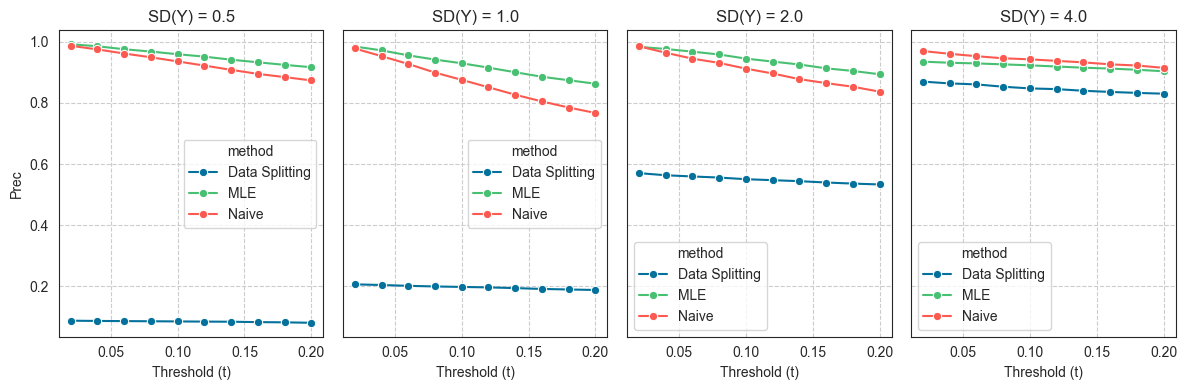

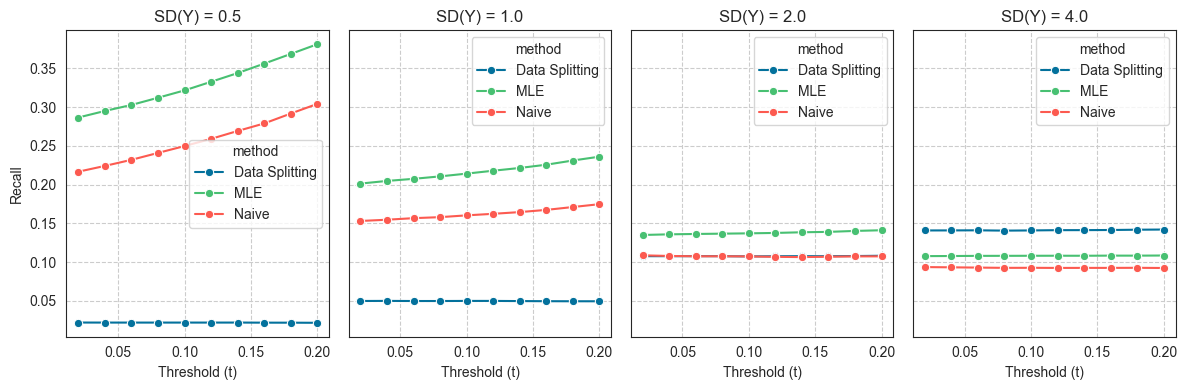

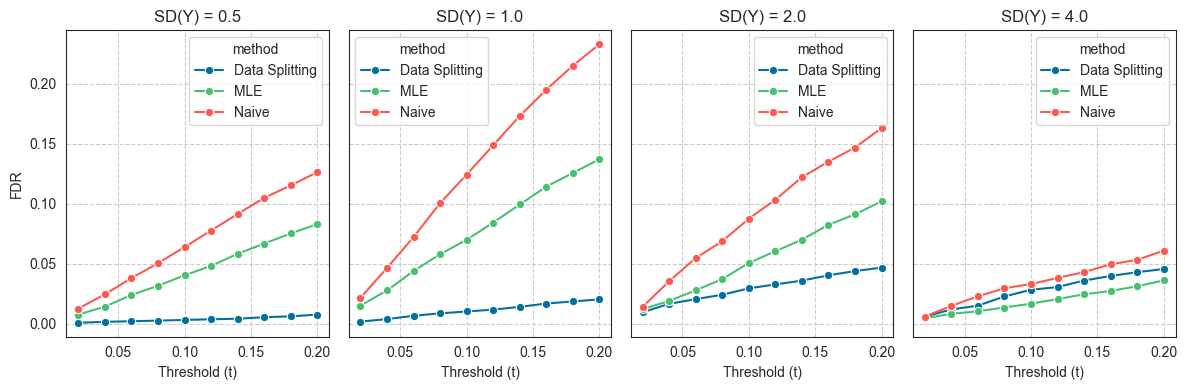

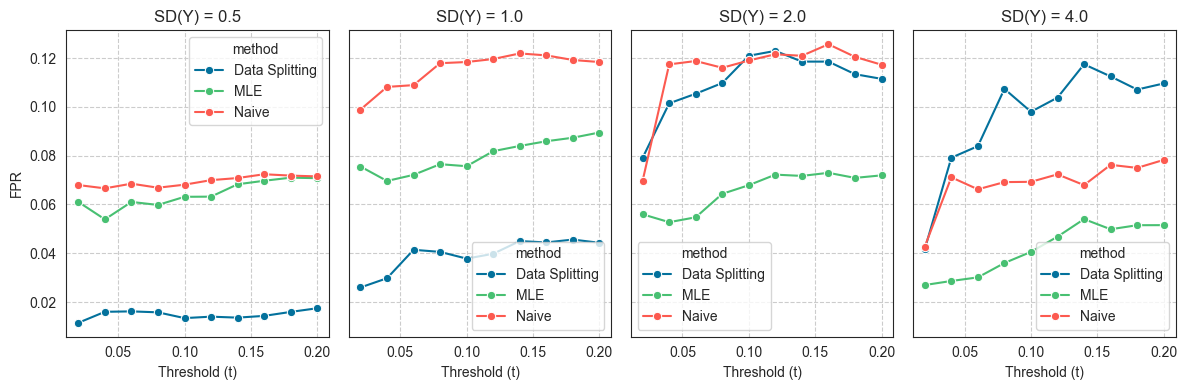

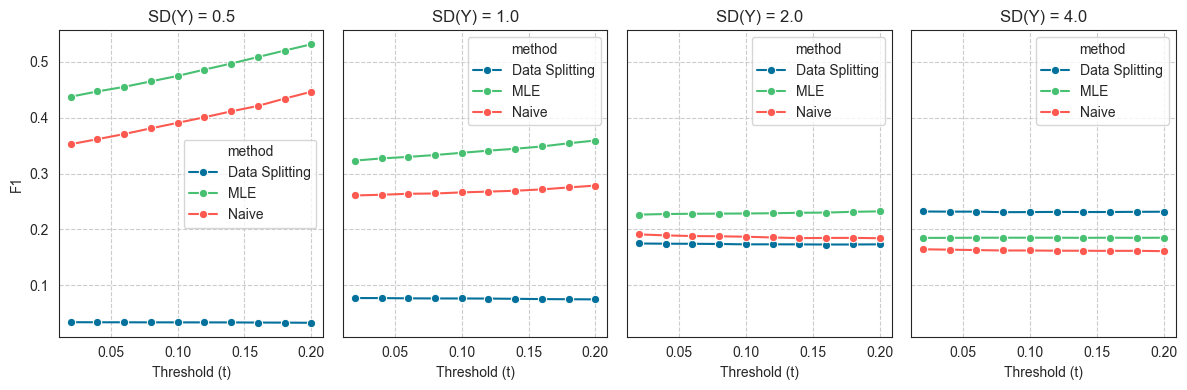

In [21]:
df_list = metric_plot(target_dict=target_dict_full, pval_key="pval",
            parameter_name="SD(Y)", 
            metric_list=["Prec", "Recall", "FDR", "FPR", "F1"],
                      rank_def_count=ds_rank_def_count_full)

In [22]:
import matplotlib.ticker as ticker
def metric_by_rejection_plot(target_dict=None, thresholds=np.array(range(1, 11)) * 0.02, level=0.1,
                pval_key="pval",
                parameter_name='parameter',
                metric_list=None,
                rank_def_count=None):
    # Collect the data for each threshold
    df = calculate_metric_df(targets_dict=target_dict,
                               threshold=0.1, level=level,
                               pval_key=pval_key,
                               metric_list=metric_list,
                               rank_def_count=rank_def_count)  # compute power(t) -> DataFrame
    df = pd.DataFrame(df).copy()  # so we can safely modify
    
    # Create bins for the number of rejections
    max_rej = df['N_rej'].max()
    bins = np.arange(0, max_rej + 20, 20)  # you can adjust the step size
    df['rejection_bin'] = pd.cut(df['N_rej'], bins=bins, include_lowest=True)

    df_plot = df
    
    """df_plot = (
        df
        .groupby(['parameter', 'method', 'N_rej'], as_index=False)
        .agg({metric: "mean" for metric in metric_list})
    )"""

    # --- 4) Create separate plots for each p ---
    figures = {}
    unique_ps = df_plot['parameter'].unique()

    def plot_one_metric(metric):
        # Create a figure with 1 row and len(unique_ps) columns
        n_p = len(unique_ps)
        fig, axes = plt.subplots(
            1,
            n_p,
            figsize=(3 * n_p, 4),  # width scales with number of p's
            sharey=True  # share y-axis if desired
        )

        # If there's only one p, axes is not a list by default, so make it a list
        if n_p == 1:
            axes = [axes]

        for i, par_val in enumerate(unique_ps):
            ax = axes[i]

            # Filter to only rows where p == p_val
            df_p = df_plot[df_plot['parameter'] == par_val]

            # Seaborn lineplot
            sns.boxplot(
                data=df_p,
                x='rejection_bin',
                y=metric,
                hue='method',
                palette=my_palette,
                #marker='o',
                ax=ax,
                showfliers=False
            )
            """
            
            #    Overlay raw data points with high transparency
            #    We'll use a "strip plot" or "swarm plot" to show individual points.
            sns.stripplot(
                data=df,
                x='N_rej',
                y=metric,
                hue='method',
                palette=my_palette,
                dodge=True,     # separate the points by 'method'
                alpha=0.05,      # transparency so points won't overwhelm the plot
                legend=False,    # don't create a second legend
                ax=ax,
                zorder=1
            )
            
            sns.lineplot(
                data=df,
                x='N_rej',
                y=metric,
                hue='method',
                palette=my_palette,
                estimator='mean',   # default is mean, but you can set e.g. np.median
                errorbar='sd',            # or None / 'sd' / 95, etc.
                legend='brief',
                ax=ax,
                linewidth=3,  # Increase thickness
                alpha=1.0,
                zorder=2
            )
            """
            ax.set_title(f'{parameter_name} = {par_val}')
            ax.set_xlabel('# Rejection')
            #ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
            ax.tick_params(axis='x', labelrotation=45)
            if i == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')  # to avoid repeating "Power(t)" on every subplot if you like

            ax.grid(True)

            # Optionally, move the legend to the first subplot only,
            # or keep them all. For a single legend, you could do:
            # if i == 0:
            #     ax.legend()
            # else:
            #     ax.get_legend().remove()

        # Optional: tighten layout
        plt.tight_layout()

        plt.show()

    for metric in metric_list:
        if metric == "N_rej":
            continue
        plot_one_metric(metric)

    return df_list

In [23]:
metric_by_rejection_plot(target_dict=target_dict_full, pval_key="pval",
                         parameter_name="SD(Y)", 
                         metric_list=["Prec", "Recall", "FDR", "FPR", "F1", "N_rej"],
                         rank_def_count=ds_rank_def_count_full)

KeyboardInterrupt: 

In [24]:
def metric_by_alpha_plot(target_dict=None, 
                         threshold=0.01, 
                         levels=[0.01, 0.05, 0.10, 0.15, 0.20, 0.25],
                pval_key="pval", 
                parameter_name='parameter', 
                metric_list=None,
                rank_def_count=ds_rank_def_count_full):
    
    # Collect the data for each threshold
    df_list = []
    for level in levels:
        df_t = calculate_metric_df(targets_dict=target_dict,
                                     threshold=threshold, level=level,
                                     pval_key=pval_key,
                                   metric_list=metric_list,
                                   rank_def_count=rank_def_count)  # compute power(t) -> DataFrame
        df_t = pd.DataFrame(df_t).copy()  # so we can safely modify
        df_t['alpha'] = level  # store which threshold was used
        df_list.append(df_t)

    # Concatenate all thresholded results
    df_all = pd.concat(df_list, ignore_index=True)

    df_plot = (
        df_all
        .groupby(['parameter', 'method', 'alpha'], as_index=False)
        .agg({metric: "mean" for metric in metric_list})
    )

    # --- 4) Create separate plots for each p ---
    figures = {}
    unique_ps = df_plot['parameter'].unique()
    
    def plot_one_metric(metric):
        # Create a figure with 1 row and len(unique_ps) columns
        n_p = len(unique_ps)
        fig, axes = plt.subplots(
            1,
            n_p,
            figsize=(3 * n_p, 4),  # width scales with number of p's
            sharey=True  # share y-axis if desired
        )
    
        # If there's only one p, axes is not a list by default, so make it a list
        if n_p == 1:
            axes = [axes]
    
        for i, par_val in enumerate(unique_ps):
            ax = axes[i]
    
            # Filter to only rows where p == p_val
            df_p = df_plot[df_plot['parameter'] == par_val]
    
            # Seaborn lineplot
            sns.lineplot(
                data=df_p,
                x='alpha',
                y=metric,
                hue='method',
                palette=my_palette,
                marker='o',
                ax=ax
            )
    
            ax.set_title(f'{parameter_name} = {par_val}')
            ax.set_xlabel(r"$\alpha$")
            if i == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')  # to avoid repeating "Power(t)" on every subplot if you like
    
            ax.grid(True)
    
            # Optionally, move the legend to the first subplot only,
            # or keep them all. For a single legend, you could do:
            # if i == 0:
            #     ax.legend()
            # else:
            #     ax.get_legend().remove()
    
        # Optional: tighten layout
        plt.tight_layout()
        
        plt.show()
        
    for metric in metric_list:
        plot_one_metric(metric)
    
    return df_list

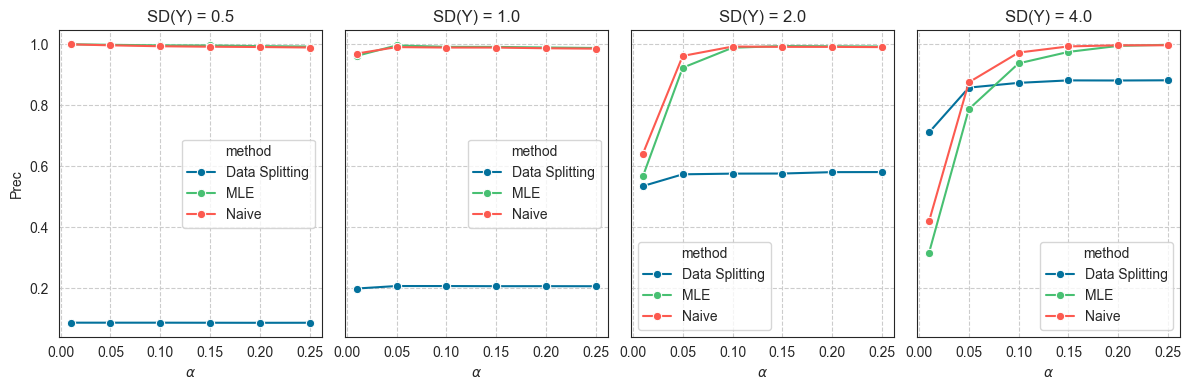

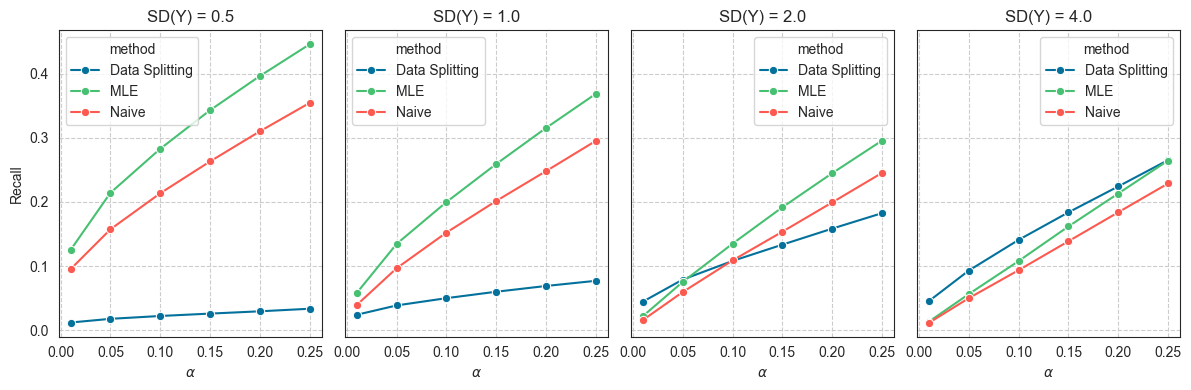

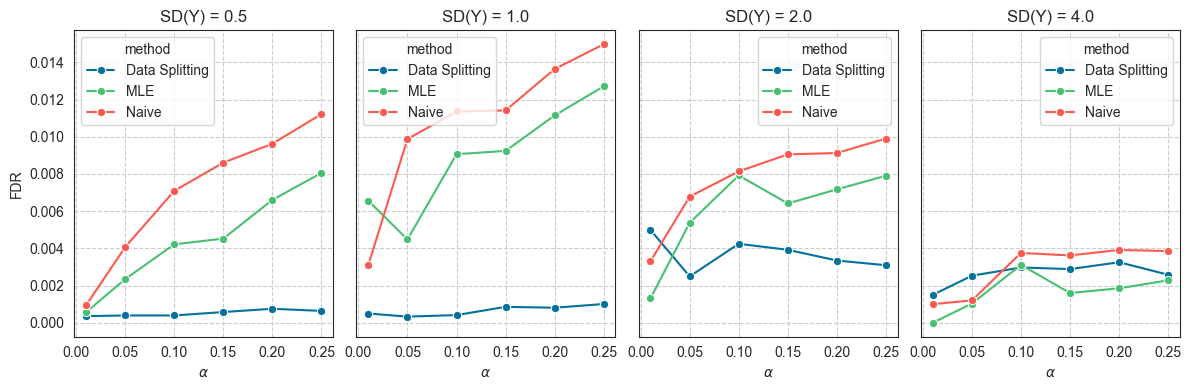

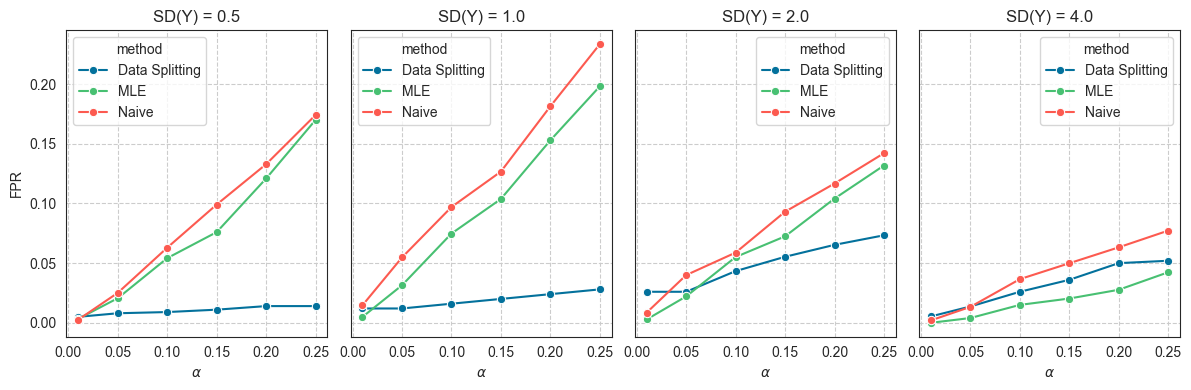

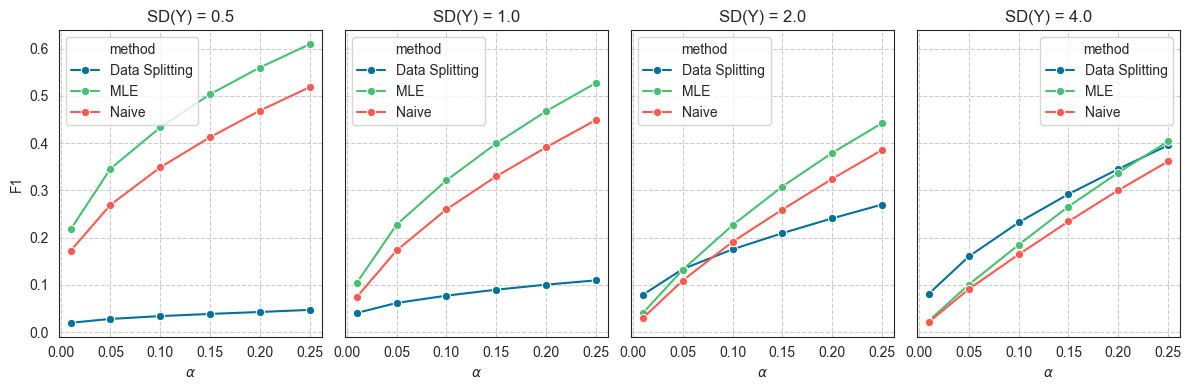

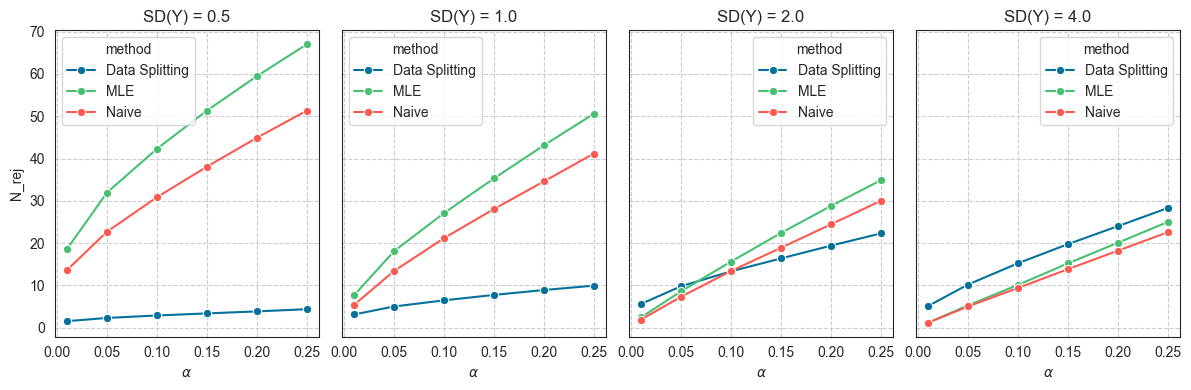

In [25]:
df_alpha = metric_by_alpha_plot(target_dict=target_dict_full, pval_key="pval",
                         parameter_name="SD(Y)", 
                         metric_list=["Prec", "Recall", "FDR", "FPR", "F1", "N_rej"],
                         rank_def_count=ds_rank_def_count_full)

In [26]:
df_alpha

[      parameter          method  Prec    Recall  FDR  FPR        F1  N_rej  \
 0           0.5  Data Splitting   0.0  0.000000  0.0  0.0  0.000000      0   
 1           0.5  Data Splitting   0.0  0.000000  0.0  0.0  0.000000      0   
 2           0.5  Data Splitting   0.0  0.000000  0.0  0.0  0.000000      0   
 3           0.5  Data Splitting   0.0  0.000000  0.0  0.0  0.000000      0   
 4           0.5  Data Splitting   0.0  0.000000  0.0  0.0  0.000000      0   
 ...         ...             ...   ...       ...  ...  ...       ...    ...   
 2995        4.0             MLE   0.0  0.000000  0.0  0.0  0.000000      0   
 2996        0.5           Naive   1.0  0.077419  0.0  0.0  0.143713     12   
 2997        1.0           Naive   0.0  0.000000  0.0  0.0  0.000000      0   
 2998        2.0           Naive   0.0  0.000000  0.0  0.0  0.000000      0   
 2999        4.0           Naive   0.0  0.000000  0.0  0.0  0.000000      0   
 
       alpha  
 0      0.01  
 1      0.01  
 2   

In [27]:
# Concatenate all thresholded results
df_all = pd.concat(df_alpha, ignore_index=True)

df_plot = (
    df_all
    .groupby(['parameter', 'method', 'alpha'], as_index=False)
    .agg({metric: "mean" for metric in ["Prec", "Recall"]})
)

# --- 4) Create separate plots for each p ---
figures = {}
unique_ps = df_plot['parameter'].unique()

In [28]:
df_plot

,parameter,method,alpha,Prec,Recall
0,0.5,Data Splitting,0.01,0.087640,0.011754
1,0.5,Data Splitting,0.05,0.087606,0.017528
2,0.5,Data Splitting,0.10,0.087606,0.021964
3,0.5,Data Splitting,0.15,0.087422,0.025694
4,0.5,Data Splitting,0.20,0.087245,0.029279
...,...,...,...,...,...
67,4.0,Naive,0.05,0.874795,0.049844
68,4.0,Naive,0.10,0.972244,0.093499
69,4.0,Naive,0.15,0.992380,0.138633
70,4.0,Naive,0.20,0.996085,0.183855


In [29]:
def plot_precision_recall(df_plot, parameter_name):
        # Create a figure with 1 row and len(unique_ps) columns
        n_p = len(unique_ps)
        fig, axes = plt.subplots(
            1,
            n_p,
            figsize=(3 * n_p, 4),  # width scales with number of p's
            sharey=True  # share y-axis if desired
        )
    
        # If there's only one p, axes is not a list by default, so make it a list
        if n_p == 1:
            axes = [axes]
    
        for i, par_val in enumerate(unique_ps):
            ax = axes[i]
    
            # Filter to only rows where p == p_val
            df_p = df_plot[df_plot['parameter'] == par_val]
    
            # Seaborn lineplot
            sns.lineplot(
                data=df_p,
                x='Recall',
                y='Prec',
                hue='method',
                palette=my_palette,
                marker='o',
                ax=ax
            )
    
            ax.set_title(f'{parameter_name} = {par_val}')
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")
            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            
    
            ax.grid(True)
    
            # Optionally, move the legend to the first subplot only,
            # or keep them all. For a single legend, you could do:
            # if i == 0:
            #     ax.legend()
            # else:
            #     ax.get_legend().remove()
    
        # Optional: tighten layout
        plt.tight_layout()
        
        plt.show()

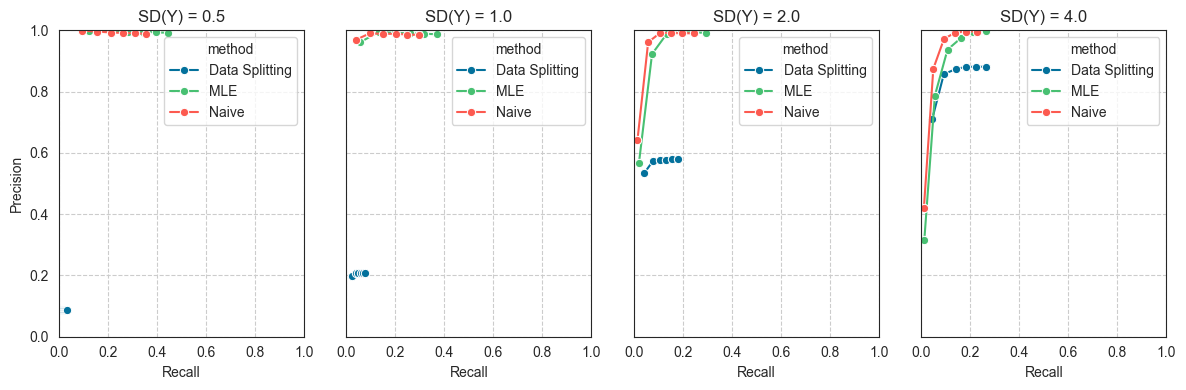

In [30]:
plot_precision_recall(df_plot, "SD(Y)")

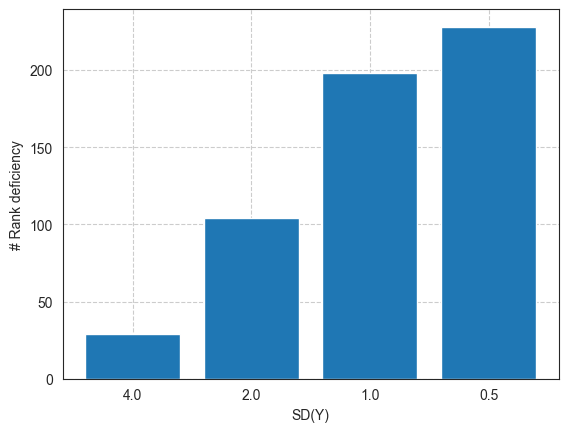

In [31]:
# Rank deficiency bar chart
D = ds_rank_def_count_full

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.xlabel("SD(Y)")
plt.ylabel("# Rank deficiency")

plt.show()